## PROJECT


Evaluation criteria: Multi Class Log Loss

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html

https://www.youtube.com/watch?v=IVVVjBSk9N0

also go with the confsion matrix

## add success criteria metric! @ kaggle page evaluation

## multiclass log loss !

In [1]:
# import numpy as np
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt
# from scipy import stats
# import source.funk as fun

# sns.set_palette('Set2')  # look at those beautiful colours

# import warnings
# warnings.filterwarnings('ignore')

# from sklearn.feature_extraction.text import TfidfVectorizer
# from nltk.corpus import stopwords

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score,log_loss
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from scipy.sparse import hstack
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from collections import Counter,defaultdict
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import math
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')

from mlxtend.classifier import StackingClassifier
import source.funk as fun

sns.set_palette('Set2')  # look at those beautiful colours

- https://towardsdatascience.com/a-step-by-step-guide-for-creating-advanced-python-data-visualizations-with-seaborn-matplotlib-1579d6a1a7d0

### DATA

In [3]:
data_text = pd.read_csv('data/training_text',sep="\|\|",engine='python',names=['ID','TEXT'],skiprows=1)
df_variants = pd.read_csv('data/training_variants')

In [4]:
data_text.head(3)

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...


In [5]:
df_variants.head(3)

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2


In [6]:
df_variants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 4 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
dtypes: int64(2), object(2)
memory usage: 103.9+ KB


In [7]:
df_variants.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [8]:
df_variants.shape

(3321, 4)

In [9]:
data_text.shape

(3321, 2)

In [10]:
data_text.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 2 columns):
ID      3321 non-null int64
TEXT    3316 non-null object
dtypes: int64(1), object(1)
memory usage: 52.0+ KB


We do have 5 missing values on TEXT data

In [11]:
data_text.columns

Index(['ID', 'TEXT'], dtype='object')

In [12]:
data_text.head()

,ID,TEXT
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [13]:
data_text.TEXT[0][0:1000]

'Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and more generally the functions of CDK10, remain elusive. Here we demonstrate that CDK10 is a cyclin-dependent kinase by identifying cyclin M as an activating cyclin. Cyclin M, an orphan cyclin, is the product of FAM58A, whose mutations cause STAR syndrome, a human developmental anomaly whose features include toe syndactyly, telecanthus, and anogenital and renal malformations. We show that STAR syndrome-associated cyclin M mutants are unable to interact with CDK10. Cyclin M silencing phenocopies CDK1

- data_text columns: ID - TEXT
- data_variants col: ID - Gene - variants - class

In [14]:
df_variants.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

MultiClass Prediction Problem

- Since we are predicting results concerning health, we can not afford high rates of errors. In other words cost of false predictions are high.

**Target Classes: df.Class**

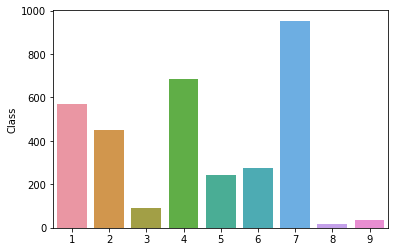

In [15]:
fun.seaborn_count_barplot(df_variants,'Class')

Imbalanced classes. Studies mostly concentrated on cancer types 7, 4, 2, 1.

And types 3, 8 ,9 are weak in numbers.

We can build a model which concentrates on dominant classes as long as it still returns reasonable signal for weaker ones.

Standard algorithms are often biased towards the dominant class. They fail to consider data distribution.

A basic yet less recomended way to deal with the unbalanced dataset issue in a multi class categorization project, is to ignore weak classes by perceiving them as outliers.

Another methadology can be oversampling such as SMOTE algoritm.

In [16]:
df_variants.Class.describe()

count    3321.000000
mean        4.365854
std         2.309781
min         1.000000
25%         2.000000
50%         4.000000
75%         7.000000
max         9.000000
Name: Class, dtype: float64

## GENE

In [17]:
df = df_variants.copy()

In [18]:
len(df.Gene.unique())

264

Thats a lot of unique Genes.

Multi Class Classification Problem because our target has 9 different variables.

In medical problems errors can be really costly so we can not afford errors.

Let's have a look at the most frequently found genes in each of the 9 classes.

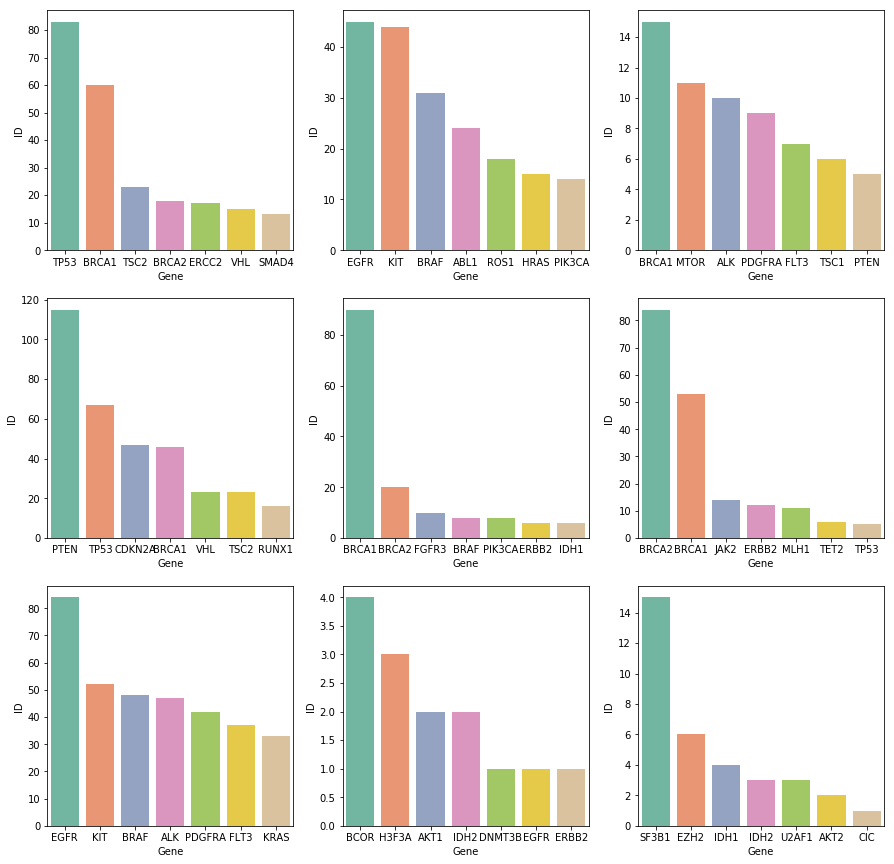

In [19]:
fig, axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i in range(3):
    for j in range(3):
        gene_count_grp = df[df["Class"]==((i*3+j)+1)].groupby('Gene')["ID"].count().reset_index()
        sorted_gene_group = gene_count_grp.sort_values('ID', ascending=False)
        sorted_gene_group_top_7 = sorted_gene_group[:7]
        sns.barplot(x="Gene", y="ID", data=sorted_gene_group_top_7, ax=axs[i][j])

**TEXT Processing: NLTK**

In [20]:
data_text.TEXT[0][0:500] 

'Cyclin-dependent kinases (CDKs) regulate a variety of fundamental cellular processes. CDK10 stands out as one of the last orphan CDKs for which no activating cyclin has been identified and no kinase activity revealed. Previous work has shown that CDK10 silencing increases ETS2 (v-ets erythroblastosis virus E26 oncogene homolog 2)-driven activation of the MAPK pathway, which confers tamoxifen resistance to breast cancer cells. The precise mechanisms by which CDK10 modulates ETS2 activity, and mor'

**Clean the text**

In [21]:
stop_words = set(stopwords.words('english'))


regular expression: https://docs.python.org/2/library/re.html

In [22]:
def data_text_preprocess(all_text, ind, col):
    # getting rid of all the integer values.
    if type(all_text) is not int:
        text = ""
        #replacing all special characters with space
        all_text = re.sub('[^a-zA-Z0-9\n]',' ', str(all_text))
        #replacing multiple spaces with a single one
        all_text = re.sub('\s+',' ',str(all_text))
        #bring whole text to same lower-case scale.
        all_text = all_text.lower()
    
        # retain only non-stop words from the transformed all_text
        for word in all_text.split():
            if not word in stop_words:
                text += word + " "
    
        data_text[col][ind] = text   

In [23]:
for index, row in data_text.iterrows():
    if type(row['TEXT']) is str:
        data_text_preprocess(row['TEXT'], index, 'TEXT')

data_text_process cleaned the text and now it is ready to be vectorized. 

In [24]:
data_text.TEXT[0][0:500]

'cyclin dependent kinases cdks regulate variety fundamental cellular processes cdk10 stands one last orphan cdks activating cyclin identified kinase activity revealed previous work shown cdk10 silencing increases ets2 v ets erythroblastosis virus e26 oncogene homolog 2 driven activation mapk pathway confers tamoxifen resistance breast cancer cells precise mechanisms cdk10 modulates ets2 activity generally functions cdk10 remain elusive demonstrate cdk10 cyclin dependent kinase identifying cyclin '

**merge**

In [25]:
df_merge = pd.merge(df_variants, data_text, on = 'ID', how= 'left')

Just want to check if I have missing data here.

In [26]:
df_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3321 entries, 0 to 3320
Data columns (total 5 columns):
ID           3321 non-null int64
Gene         3321 non-null object
Variation    3321 non-null object
Class        3321 non-null int64
TEXT         3316 non-null object
dtypes: int64(2), object(3)
memory usage: 155.7+ KB


In [27]:
df_merge[df_merge.isnull().any(axis=1)]

,ID,Gene,Variation,Class,TEXT
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


Looks like we do not have any missing values. In any case for future reference if we had missing TEXT data:

- we could drop them( I do not recomend that because we have a imited number of data points)
- we could replace them with what we have in the hand with an expectancy that, it is going to matter.

We have variation and gene information.  As I already had a look at the text data, these variations and gene names are being mention quite a lot in the text data. So, instead of dropping the null texts, let me add something meaningful to that.

In [28]:
df_merge.loc[df_merge['TEXT'].isnull(),'TEXT'] = df_merge['Gene'] + " " + df_merge['Variation']

Cross Check

In [29]:
df_merge[df_merge.isnull().any(axis=1)]  #looks pretty clean!

,ID,Gene,Variation,Class,TEXT


A final touch the the Gene and Variation: We shall replace spaces with non-spaces or something like "_".

In [30]:
df_merge['Gene']       =  df_merge['Gene'].str.replace('\s+','_')
df_merge['Variation']  =  df_merge['Variation'].str.replace('\s+','_')

In [31]:
df_merge['Variation'].value_counts().head(1)  #done

Truncating_Mutations    93
Name: Variation, dtype: int64

In [32]:
df = df_merge

## Training and Validation(test)

I will hold out the test set and create/improve the model with training and cross validated data.

In [33]:
y = df['Class'].values

In [34]:
df_in = df.drop('ID',axis=1)

In [35]:
X_train,   test_df, y_train, y_test = train_test_split(df_in     , y,       stratify = y,       test_size = 0.2, random_state = 42)
train_df, df_cv, y_train, y_cv =      train_test_split(X_train, y_train, stratify = y_train, test_size = 0.2, random_state = 95)

Since we have limited number of data points it is critical to check the distribution of the data. We do not want distributional variations among train, validation and test sets. In other words, the data among different sets shall follow a smilar pattern.

Have a look

In [36]:
print(train_df.shape[0])
print(test_df.shape[0])
print(df_cv.shape[0])

2124
665
532


Target Distributions between train and cv (test set is holdout!)

In [37]:
def class_balance(df,target):
    fun.seaborn_count_barplot(df,target)
    
    y_sort = np.argsort(- df.Class.value_counts().values)
    for i in y_sort:
        print("Number of data points in class", i+1, ":", df.Class.value_counts().values[i],"(",np.round((df.Class.value_counts().values[i]/df.shape[0]*100),1),'% )')

Number of data points in class 1 : 609 ( 28.7 % )
Number of data points in class 2 : 439 ( 20.7 % )
Number of data points in class 3 : 363 ( 17.1 % )
Number of data points in class 4 : 289 ( 13.6 % )
Number of data points in class 5 : 176 ( 8.3 % )
Number of data points in class 6 : 155 ( 7.3 % )
Number of data points in class 7 : 57 ( 2.7 % )
Number of data points in class 8 : 24 ( 1.1 % )
Number of data points in class 9 : 12 ( 0.6 % )


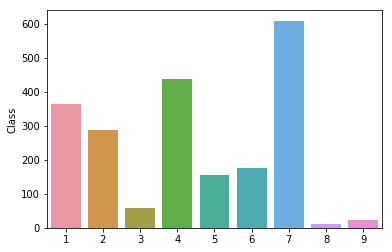

In [38]:
class_balance(train_df,'Class')

Number of data points in class 1 : 191 ( 28.7 % )
Number of data points in class 2 : 137 ( 20.6 % )
Number of data points in class 3 : 114 ( 17.1 % )
Number of data points in class 4 : 91 ( 13.7 % )
Number of data points in class 5 : 55 ( 8.3 % )
Number of data points in class 6 : 48 ( 7.2 % )
Number of data points in class 7 : 18 ( 2.7 % )
Number of data points in class 8 : 7 ( 1.1 % )
Number of data points in class 9 : 4 ( 0.6 % )


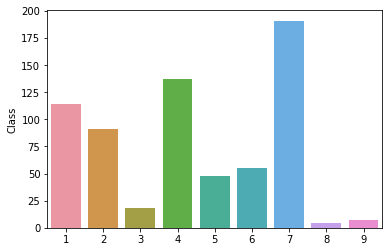

In [39]:
class_balance(test_df,'Class')

Number of data points in class 1 : 153 ( 28.8 % )
Number of data points in class 2 : 110 ( 20.7 % )
Number of data points in class 3 : 91 ( 17.1 % )
Number of data points in class 4 : 72 ( 13.5 % )
Number of data points in class 5 : 44 ( 8.3 % )
Number of data points in class 6 : 39 ( 7.3 % )
Number of data points in class 7 : 14 ( 2.6 % )
Number of data points in class 8 : 6 ( 1.1 % )
Number of data points in class 9 : 3 ( 0.6 % )


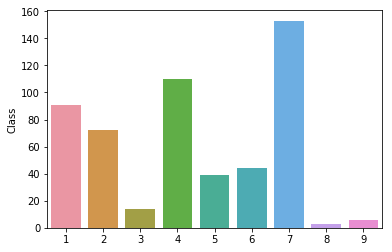

In [40]:
class_balance(df_cv,'Class')

The distributions of the target classes look smilar. Thereby we can proceed.

However as mentioned number of classes are not balanced.

## MultiClass Baseline Model

Lets build a baseline model with 9 target classes in order to compute the logloss which we will use as a benchmark for improvement.

In [41]:
test_data_len = test_df.shape[0]
cv_data_len   = df_cv.shape[0]

In [42]:
cv_data_len

532

Generate an output array with the size of cross validated data.

In [43]:
cv_predicted_y = np.zeros((cv_data_len,9)) # 9 for 9 classes

for i in range(cv_data_len):
    rand_probs = np.random.rand(1,9)   #randomly assigning numbers from 1 to 9 inclusive
    cv_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Random model's Log loss on CV Data is", log_loss(y_cv,cv_predicted_y, eps=1e-15))

Random model's Log loss on CV Data is 2.510114076628458


What does it mean? well that 2.51 is our baseline score. From this point, whatever model we create we want to have a smaller Log loss score than 2.51

In [44]:
test_predicted_y = np.zeros((test_data_len,9)) # 9 for 9 classes

for i in range(test_data_len):
    rand_probs = np.random.rand(1,9)   #randomly assigning numbers from 1 to 9 inclusive
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Random model's Log loss on Test Data is", log_loss(y_test,test_predicted_y, eps=1e-15))

Random model's Log loss on Test Data is 2.503773775552918


The index for max probability.

In other words the predictions which return the highest probability.

In [45]:
predicted_y = np.argmax(test_predicted_y, axis=1)
predicted_y[0:20]

array([0, 5, 8, 1, 5, 4, 4, 5, 4, 1, 2, 4, 6, 0, 0, 3, 2, 8, 5, 6])

In [46]:
print(predicted_y.min())
print(predicted_y.max())

0
8


Reminder, the numbers stands for the predictions from 1 to 9 however their range is different. Lets change that.

In [47]:
predicted_y = predicted_y + 1

## Scoring on Baseline Model

In [48]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

**confusion matrix:** https://www.youtube.com/watch?v=Kdsp6soqA7o

In [49]:
C = confusion_matrix(y_test,predicted_y)

The target is made of 9 classes. So the shape of confusion matrix shall be 9*9

In [50]:
C.shape

(9, 9)

In [51]:
C

array([[18,  9, 11, 14, 20, 14, 11, 12,  5],
       [12, 10,  6, 10,  7, 12, 16, 11,  7],
       [ 3,  2,  2,  0,  3,  3,  3,  2,  0],
       [11, 24, 19, 15, 11, 14, 13, 17, 13],
       [ 4,  4,  8,  2,  8,  6,  5,  5,  6],
       [ 8,  6,  7,  8,  6,  4,  8,  2,  6],
       [22, 20, 28, 33, 21, 18, 16, 10, 23],
       [ 0,  0,  1,  1,  1,  0,  0,  1,  0],
       [ 1,  3,  0,  0,  1,  1,  0,  0,  1]])

Heatmap Confusion Matrix

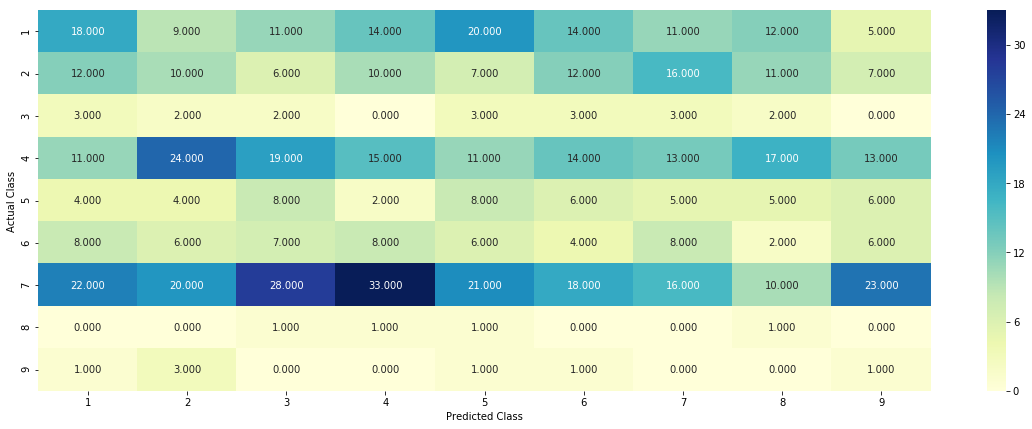

In [52]:
labels = list(np.linspace(1, 9, num=9, dtype = int))
plt.figure(figsize =(20,7))
sns.heatmap(C, annot = True, cmap = "YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

How to interpret that? 

Lets focus on the first column, predicted class :1

Looks like classess 3-5-6-8-9 are really distinct from class 1 due to the fact that number of times the model predicted those classes as class 1 is relatively low.

Whereas the model predicted classes 7-4 and 2 to be class 1, which are all errors compared to low number of TP results for 1.

## Precision Matrix

In [53]:
precision = (C/ C.sum(axis=0))

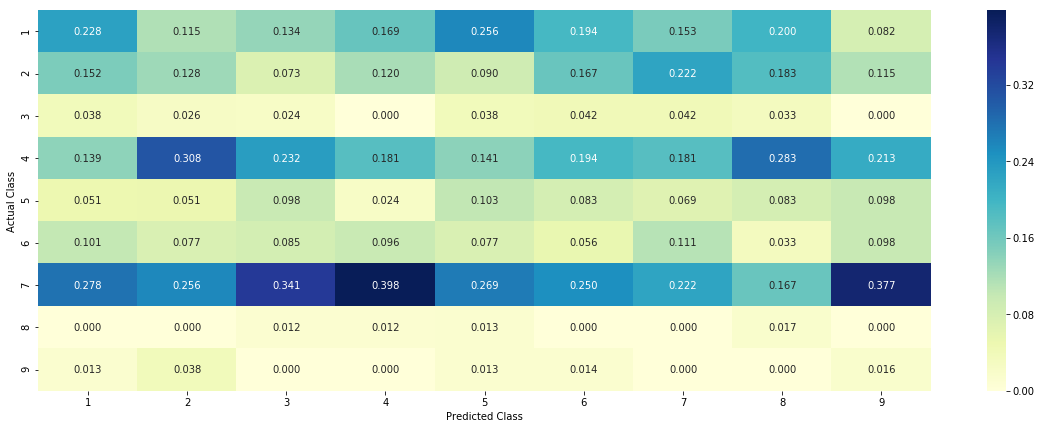

In [54]:
labels = list(np.linspace(1, 9, num=9, dtype = int))
plt.figure(figsize =(20,7))
sns.heatmap(precision, annot = True, cmap = "YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.show()

predicted and actual 1: of all the classes that predicted to be class 1, 23% were accurate.

Well this is usefull for visulization however there is a better way to interpret the model.

**Classification Report**

In [55]:
CR = classification_report(y_test,predicted_y)

In [56]:
print(CR)

              precision    recall  f1-score   support

           1       0.23      0.16      0.19       114
           2       0.13      0.11      0.12        91
           3       0.02      0.11      0.04        18
           4       0.18      0.11      0.14       137
           5       0.10      0.17      0.13        48
           6       0.06      0.07      0.06        55
           7       0.22      0.08      0.12       191
           8       0.02      0.25      0.03         4
           9       0.02      0.14      0.03         7

   micro avg       0.11      0.11      0.11       665
   macro avg       0.11      0.13      0.09       665
weighted avg       0.17      0.11      0.13       665



f1-score is a scoring parameter that considers both precision and recall with respect to their weights. 

It can be seen that the baseline model returns baseline results. The model performed badly from point of view of all classes.

### Feature : Gene

Lets have a look at the relevance of the independent features compares to the dependent target.

EDA

In [57]:
unique_genes = train_df['Gene'].value_counts()
print('Number of Unique Genes are ', unique_genes.shape[0])
print('\nTop 10 frequently found genes')
print(unique_genes.head(10))

Number of Unique Genes are  228

Top 10 frequently found genes
BRCA1     158
TP53      102
EGFR       94
BRCA2      80
PTEN       80
KIT        64
BRAF       55
ALK        44
ERBB2      43
PDGFRA     42
Name: Gene, dtype: int64


Cummulative Distribution

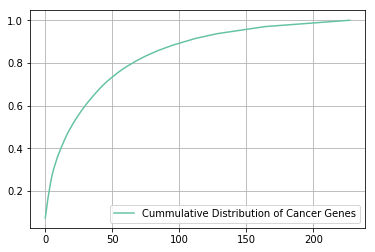

In [58]:
s = sum(unique_genes.values)
h = unique_genes.values / s
c = np.cumsum(h)
plt.plot(c,label = 'Cummulative Distribution of Cancer Genes')
plt.grid()
plt.legend()
plt.show()

- Looking at the most frequently found top 50 values, they account for almost 75% of the complete data.
- These values may be prone to overfit or the less significant genes may be prone to underfit.

**Data Transformation**

Vecrorize the genes so the machine learning model can learn from them.

options
- One Hot Encoding

May cause dimentionality issues especially when data is scarce and number of unique categorical features are high.


- Response Encoding

Imputes mean in accordance to the target.

Instead of creating dummy features which can be very high in numbers when the number of categorical variables are high. It creates dummy features which are equavelent to number of categorical classes of the target.

In our case this will lead to generation of 9 dummy variables instead of 228 variables which helps to control dimentionality issues.



Use both and compare.

In [59]:
from sklearn.feature_extraction.text import CountVectorizer

In [60]:
#one hot encoding
gene_vectorizer = CountVectorizer()
train_gene_feature_onehotCoding = gene_vectorizer.fit_transform(train_df['Gene'])
test_gene_feature_onehotCoding = gene_vectorizer.transform(test_df['Gene'])
cv_gene_feature_onehotCoding = gene_vectorizer.transform(df_cv['Gene'])


In [61]:
len(train_df.Gene.unique())

228

In [62]:
# train_gene_ferature_onehotCoding.shape[1]  # a lot of dummy variables

In [63]:
gene_vectorizer.get_feature_names()[0:10]

['abl1', 'acvr1', 'ago2', 'akt1', 'akt2', 'akt3', 'alk', 'apc', 'ar', 'araf']

**response_encoding**

In [64]:
def get_gv_fea_dict(alpha,feature,df):
    
    value_count = train_df[feature].value_counts()
    
    gv_dict = {}
    
    for i, denominator in value_count.items():
        
        vec = []
        for k in range(1,10):
            
            cls_cnt = train_df.loc[(train_df['Class'] == k) & (train_df[feature]==i)]
            vec.append((cls_cnt.shape[0]+alpha*10)/ denominator + 90 * alpha)
        gv_dict[i] = vec
    return gv_dict
            

In [65]:
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha,feature,df)
    value_count = train_df[feature].value_counts()
    
    gv_fea = []
    
    for index,row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea
        

In [66]:
#response-encoding of the Gene Feature
# alpha is used for laplace smoothing
alpha = 1
#train gene feature
train_gene_feature_responseCoding = np.array(get_gv_feature(alpha,'Gene',train_df))
#test gene feature
test_gene_feature_responseCoding = np.array(get_gv_feature(alpha,'Gene',test_df))
#cross validation gene feature
cv_gene_feature_responseCoding = np.array(get_gv_feature(alpha,"Gene",df_cv))

Lets look at the new form of the columns

The result shall include 9 columns as dummy variables for Gene column.

In [67]:
train_gene_feature_responseCoding.shape

(2124, 9)

In [68]:
test_gene_feature_responseCoding.shape

(665, 9)

In [69]:
train_gene_feature_responseCoding[0]

array([91.375, 91.375, 91.25 , 92.   , 91.25 , 91.25 , 91.25 , 91.25 ,
       91.25 ])

How to check the value add of the response encoding results?


Let's compare the logloss of the model in newly generated dummy variables with the baseline score.

In case logloss of model that is trained with a single feature is lesser than the baseline score, that means response encoding did a good job.


Setting up hyper parameters for SGD classifier.

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [70]:
alpha = [10 ** x for x in range(-5,1)]

Calibrated classifier so that the model will return the results in terms of probability.

In [71]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

In [72]:
cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(alpha =i,penalty='l2',loss = 'log',random_state=42)
    clf.fit(train_gene_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf,method = 'sigmoid')
    sig_clf.fit(train_gene_feature_onehotCoding,y_train)
    predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv,predict_y,labels = clf.classes_,eps=1e-15))
    print('For values of alpha = ',i, 'The log loss is:',log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
    

For values of alpha =  1e-05 The log loss is: 1.392997119735486
For values of alpha =  0.0001 The log loss is: 1.2310356047100817
For values of alpha =  0.001 The log loss is: 1.2559745413330443
For values of alpha =  0.01 The log loss is: 1.3703214120380807
For values of alpha =  0.1 The log loss is: 1.442410040621252
For values of alpha =  1 The log loss is: 1.4701681796644472


Plot it and have a look.

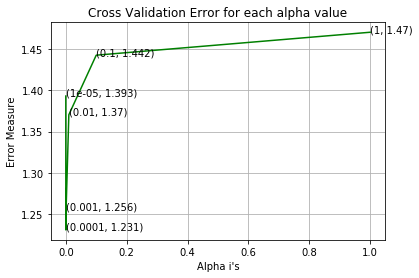

In [73]:
fig, ax = plt.subplots()
ax.plot(alpha,cv_log_error_array,c = 'g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title('Cross Validation Error for each alpha value')
plt.xlabel("Alpha i's")
plt.ylabel('Error Measure')
plt.show()

Certainly the best alpha value is the one which returns the smallest error(argmin to get it out)

And get the log loss.

In [74]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l2',loss='log',random_state=42)
clf.fit(train_gene_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_gene_feature_onehotCoding,y_train)

predict_y = sig_clf.predict_proba(train_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha],'The TRAIN log loss is:',log_loss(y_train,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha],'The VALIDATION(CV) log loss is:',log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha],'The TEST log loss is:',log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))



For values of best alpha =  0.0001 The TRAIN log loss is: 1.0155149253123341
For values of best alpha =  0.0001 The VALIDATION(CV) log loss is: 1.2310356047100817
For values of best alpha =  0.0001 The TEST log loss is: 1.268972427427352


Now lets check how many values are overlapping among train, cv and test.

In [75]:
test_coverage = test_df[test_df['Gene'].isin(list(set(train_df['Gene'])))].shape[0]
cv_coverage = df_cv[df_cv['Gene'].isin(list(set(train_df['Gene'])))].shape[0]

In [76]:
print('1. In test data', test_coverage, 'out of',test_df.shape[0],':',(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data', cv_coverage, 'out of',df_cv.shape[0],':',(cv_coverage/df_cv.shape[0])*100)

1. In test data 640 out of 665 : 96.2406015037594
2. In cross validation data 511 out of 532 : 96.05263157894737


# FEATURE: VARIATION (evaluate)

Variation is also a categorical variable so we have to deal in same way like we have done for **Gene** feature. We will again get the one hot encoder and response encoding variable for variation feature.

In [77]:
unique_variations = train_df['Variation'].value_counts()
print('Number of Unique Variations :', unique_variations.shape[0])
# top 10
print(unique_variations.head(10))

Number of Unique Variations : 1927
Truncating_Mutations    58
Amplification           51
Deletion                48
Fusions                 19
Q61R                     3
G12V                     3
E330K                    2
P130S                    2
G13D                     2
Overexpression           2
Name: Variation, dtype: int64


Cumulative distribution of unique variation values:

[0.02730697 0.05131827 0.07391714 ... 0.99905838 0.99952919 1.        ]


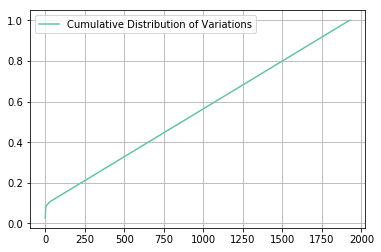

In [78]:
s = sum(unique_variations.values)
h = unique_variations.values / s
c = np.cumsum(h)
print(c)
plt.plot(c,label='Cumulative Distribution of Variations')
plt.grid()
plt.legend()
plt.show()

Transform the Variationsusing one hot encoder.

In [79]:
#one hot encoding
variation_vectorizer = CountVectorizer()
train_variation_feature_onehotCoding = variation_vectorizer.fit_transform(train_df['Variation'])
test_variation_feature_onehotCoding = variation_vectorizer.transform(test_df['Variation'])
cv_variation_feature_onehotCoding = variation_vectorizer.transform(df_cv['Variation'])


In [80]:
train_variation_feature_onehotCoding.shape

(2124, 1961)

Response encoding on feature variation.

In [81]:
#response-encoding of the Gene Feature
# alpha is used for laplace smoothing
alpha = 1
#train gene feature
train_variation_feature_responseCoding = np.array(get_gv_feature(alpha,'Variation',train_df))
#test gene feature
test_variation_feature_responseCoding =  np.array(get_gv_feature(alpha,'Variation',test_df))
#cross validation gene feature
cv_variation_feature_responseCoding =    np.array(get_gv_feature(alpha,'Variation',df_cv))

**train**

In [82]:
train_variation_feature_responseCoding.shape

(2124, 9)

In [83]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2124 entries, 1635 to 1107
Data columns (total 4 columns):
Gene         2124 non-null object
Variation    2124 non-null object
Class        2124 non-null int64
TEXT         2124 non-null object
dtypes: int64(1), object(3)
memory usage: 83.0+ KB


In [84]:
train_df.columns

Index(['Gene', 'Variation', 'Class', 'TEXT'], dtype='object')

**test**

In [85]:
test_variation_feature_responseCoding.shape

(665, 9)

In [86]:
test_df.shape

(665, 4)

In [87]:
test_df.columns

Index(['Gene', 'Variation', 'Class', 'TEXT'], dtype='object')

**cv**

In [88]:
cv_variation_feature_responseCoding.shape

(532, 9)

In [89]:
df_cv.shape

(532, 4)

In [90]:
train_variation_feature_responseCoding.shape

(2124, 9)

The model trained with only variation.

In [91]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

alpha = [10 ** x for x in range(-5,1)]

cv_log_error_array = []

for i in alpha:
    clf = SGDClassifier(alpha =i,penalty='l2',loss = 'log',random_state=42)
    clf.fit(train_variation_feature_onehotCoding, y_train)
    sig_clf = CalibratedClassifierCV(clf,method = 'sigmoid')
    sig_clf.fit(train_variation_feature_onehotCoding,y_train)
    predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv,predict_y,labels = clf.classes_,eps=1e-15))
    print('For values of alpha = ',i, 'The log loss is:',log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
    

For values of alpha =  1e-05 The log loss is: 1.6882497582014921
For values of alpha =  0.0001 The log loss is: 1.6826103958518324
For values of alpha =  0.001 The log loss is: 1.6804435166599303
For values of alpha =  0.01 The log loss is: 1.686613198314666
For values of alpha =  0.1 The log loss is: 1.6871887125184886
For values of alpha =  1 The log loss is: 1.6898985159531996


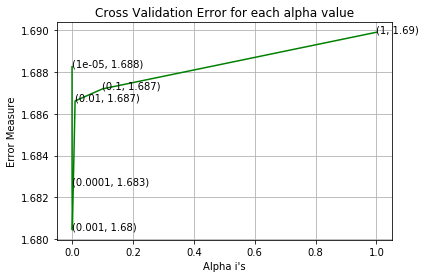

In [92]:
fig, ax = plt.subplots()
ax.plot(alpha,cv_log_error_array,c = 'g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title('Cross Validation Error for each alpha value')
plt.xlabel("Alpha i's")
plt.ylabel('Error Measure')
plt.show()

In [93]:
best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha = alpha[best_alpha], penalty='l2',loss='log',random_state=42)
clf.fit(train_variation_feature_onehotCoding, y_train)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_variation_feature_onehotCoding,y_train)

predict_y = sig_clf.predict_proba(train_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha],'The TRAIN log loss is:',log_loss(y_train,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(cv_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha],'The VALIDATION(CV) log loss is:',log_loss(y_cv,predict_y,labels=clf.classes_,eps=1e-15))
predict_y = sig_clf.predict_proba(test_variation_feature_onehotCoding)
print('For values of best alpha = ', alpha[best_alpha],'The TEST log loss is:',log_loss(y_test,predict_y,labels=clf.classes_,eps=1e-15))



For values of best alpha =  0.001 The TRAIN log loss is: 1.0442246103084027
For values of best alpha =  0.001 The VALIDATION(CV) log loss is: 1.6804435166599303
For values of best alpha =  0.001 The TEST log loss is: 1.726724164019017


In [94]:
test_coverage = test_df[test_df['Variation'].isin(list(set(train_df['Variation'])))].shape[0]
cv_coverage = df_cv[df_cv['Variation'].isin(list(set(train_df['Variation'])))].shape[0]

In [95]:
print('1. In test data', test_coverage, 'out of',test_df.shape[0],':',(test_coverage/test_df.shape[0])*100)
print('2. In cross validation data', cv_coverage, 'out of',df_cv.shape[0],':',(cv_coverage/df_cv.shape[0])*100)

1. In test data 65 out of 665 : 9.774436090225564
2. In cross validation data 60 out of 532 : 11.278195488721805


### Evaluating Feature: Text

In [96]:
# extract_dictionary_paddle function:
#for every row in the data frame, go for the 'TEXT'
#split the words by space
# make a dict with those words
# increment its count every time the word is found.

# get the count of each word                                                                                                                                                 
def extract_dictionary_paddle(cls_text):
    dictionary = defaultdict(int)
    for index,row in cls_text.iterrows():
        for word in row['TEXT'].split():
            dictionary[word] += 1 
    return dictionary

In [97]:
# response encoding


def get_text_responsecoding(df):
    text_feature_responseCoding = np.zeros((df.shape[0],9))
    for i in range(0,9):
        row_index = 0
        for index,row in df.iterrows():
            sum_prob = 0
            for word in row['TEXT'].split():
                sum_prob += math.log(((dict_list[i].get(word,0)+10)/ (total_dict.get(word,0)+90)))
            text_feature_responseCoding[row_index][i] = math.exp(sum_prob/len(row['TEXT'].split()))
            row_index += 1
    return text_feature_responseCoding

In [98]:
def get_gv_feature(alpha, feature, df):
    gv_dict = get_gv_fea_dict(alpha,feature,df)
    value_count = train_df[feature].value_counts()
    
    gv_fea = []
    
    for index,row in df.iterrows():
        if row[feature] in dict(value_count).keys():
            gv_fea.append(gv_dict[row[feature]])
        else:
            gv_fea.append([1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9,1/9])
    return gv_fea

In [99]:
#building a CountVectorizer with all the words that occured minimum 3 times in train data
text_vectorizer = CountVectorizer(min_df=3)  # otherwise there will be too many columns to come up.

# if i don;t transform the data type to unicode the following raises an error
# train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'].values.astype('U'))
train_text_feature_onehotCoding = text_vectorizer.fit_transform(train_df['TEXT'])
# All the feature names(words)
train_text_features = text_vectorizer.get_feature_names()

#train_text_feature_onehotCoding.sum(axis=0).A1 will sum every row and return (1*#of features vector)
train_text_fea_counts = train_text_feature_onehotCoding.sum(axis=0).A1

#zip(list(text_features),text_fea_counts) will zip a word with its number of times it occurs
text_fea_dict = dict(zip(list(train_text_features),train_text_fea_counts))

print('Total number of unique words in train data :', len(train_text_features))

Total number of unique words in train data : 53492


In [100]:
dict_list = []
#dict_list = [] contains 9 dictionaries each corresponds to a class
for i in range(1,10):
    cls_text = train_df[train_df['Class']==i]
    #build a word dict based on the words in that class
    cls_text.TEXT = cls_text.TEXT.astype(str)
    dict_list.append(extract_dictionary_paddle(cls_text))
    #append it to dict_list

#dict_list[i] is built on i'th class text data
#total_dict is built on whole training text data
total_dict = extract_dictionary_paddle(train_df)

confuse_array = []
for i in train_text_features:
    ratios = []
    max_val = -1
    for j in range(0,9):
        ratios.append((dict_list[j][i]+10)/ (total_dict[i]+90))
    confuse_array.append(ratios)
confuse_array = np.array(confuse_array)


In [101]:
# Response Encoding of Text Features
train_text_feature_responseCoding = get_text_responsecoding(train_df)
test_text_feature_responseCoding  = get_text_responsecoding(test_df)
cv_text_feature_responseCoding    = get_text_responsecoding(df_cv)

In [102]:
print(train_text_feature_responseCoding.shape)
print(test_text_feature_responseCoding.shape)
print(cv_text_feature_responseCoding.shape)


(2124, 9)
(665, 9)
(532, 9)


In [103]:
print('test')

test


In [104]:
# convert each row so that it sums up to 1
train_text_feature_responseCoding = (train_text_feature_responseCoding.T/train_text_feature_responseCoding.sum(axis=1)).T
test_text_feature_responseCoding =  ( test_text_feature_responseCoding.T/ test_text_feature_responseCoding.sum(axis=1)).T
cv_text_feature_responseCoding =    (   cv_text_feature_responseCoding.T/cv_text_feature_responseCoding.sum(axis=1)).T

In [105]:
print(train_text_feature_responseCoding.shape)
print(test_text_feature_responseCoding.shape)
print(cv_text_feature_responseCoding.shape)

(2124, 9)
(665, 9)
(532, 9)


In [106]:
#normalizing features
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding,axis=0)

test_text_feature_onehotCoding = text_vectorizer.transform(test_df['TEXT'])
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding,axis=0)

cv_text_feature_onehotCoding = text_vectorizer.transform(df_cv['TEXT'])
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding,axis=0)

In [107]:
cv_text_feature_onehotCoding

<532x53492 sparse matrix of type '<class 'numpy.float64'>'
	with 827534 stored elements in Compressed Sparse Column format>

In [108]:
sorted_text_fea_dict = dict(sorted(text_fea_dict.items(), key = lambda x: x[1],reverse = True))
sorted_text_occur = np.array(list(sorted_text_fea_dict.values()))

The following returns the number of times that a word appears x times in a text.

In [109]:
# print(Counter(sorted_text_occur))

Building the model with feature **TEXT** alone

In [110]:
cv_log_error_array = []
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty = 'l2', loss = 'log', random_state = 42)
    clf.fit(train_text_feature_onehotCoding, y_train)
    
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(train_text_feature_onehotCoding, y_train)
    predict_y = sig_clf.predict_proba(cv_text_feature_onehotCoding)
    cv_log_error_array.append(log_loss(y_cv,predict_y,labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y,labels=clf.classes_, eps=1e-15))

For values of alpha =  1e-05 The log loss is: 1.393294821186917
For values of alpha =  0.0001 The log loss is: 1.345441092097567
For values of alpha =  0.001 The log loss is: 1.2521881459320086
For values of alpha =  0.01 The log loss is: 1.3101497486912244
For values of alpha =  0.1 The log loss is: 1.41944058752726
For values of alpha =  1 The log loss is: 1.6080845578192446


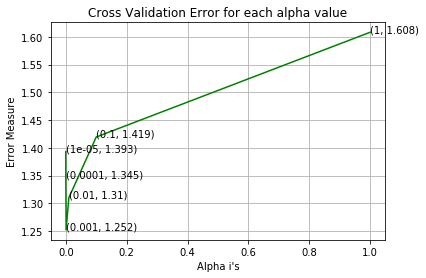

In [111]:
fig, ax = plt.subplots()
ax.plot(alpha,cv_log_error_array,c = 'g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title('Cross Validation Error for each alpha value')
plt.xlabel("Alpha i's")
plt.ylabel('Error Measure')
plt.show()

Check the Overlap of the Data

In [112]:
def get_intersec_text(df):
    df_text_vec = CountVectorizer(min_df=3)
    df_text_fea = df_text_vec.fit_transform(df['TEXT'])
    df_text_features = df_text_vec.get_feature_names()
    
    df_text_fea_counts = df_text_fea.sum(axis=0).A1
    df_text_fea_dict = dict(zip(list(df_text_features),df_text_fea_counts))
    len1 = len(set(df_text_features))
    len2 = len(set(train_text_features) & set(df_text_features))
    return len1,len2

In [113]:
len1, len2 = get_intersec_text(test_df)
print(np.round((len2/len1)*100,3), "% of word of test data appeared in train")
len1,len2 = get_intersec_text(df_cv)
print(np.round((len2/len1)*100,3), "% of word of cross validation data appeared in train")

95.711 % of word of test data appeared in train
97.795 % of word of cross validation data appeared in train


# Data Preparation For ML

Simply returns the logloss.

In [114]:
def report_log_loss(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method = 'sigmoid')
    sig_clf.fit(X_train, y_train)
    sig_clf_probs = sig_clf.predict_proba(X_test)
    return log_loss(y_test, sig_clf_probs, eps = 1e-15)

In [115]:
def plot_confusion_matrix(y_test,y_predict):
    
    C = confusion_matrix(y_test, y_predict)  #confusion matrix
    
    A = (((C.T)/(C.sum(axis=1))).T)  # precision matrix
    
    B= (C/C.sum(axis=0))    # recall matrix
    labels = list(np.linspace(1, 9, num=9, dtype = int))
    
    print("-" * 20, 'Confusion Matrix', '-' *20)
    plt.figure(figsize=(20,7))
    sns.heatmap(C,annot=True,cmap= "Y1GnBu",fmt = ".3f",xticklabels = labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()
    
    
    print("-" * 20, 'Precision Matrix', '-' *20) 
    plt.figure(figsize =(20,7))
    sns.heatmap(B, annot = True, cmap = "YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

    print("-" * 20, 'Recall Matrix', '-' *20) 
    plt.figure(figsize =(20,7))
    sns.heatmap(A, annot = True, cmap = "YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

In [116]:
def predict_and_plot_confusion_matrix(X_train,y_train,X_test, y_test, clf):
    clf.fit(X_train,y_train)
    sig_clf = CalibratedClassifierCV(clf, method='sigmoid')
    sig_clf.fit(X_train, y_train)
    pred_y = sig_clf.predict(X_test)
    
    print('Log Loss:', log_loss(y_test, sig_clf.predict_proba(X_test)))
    
    print('Number of mis-classified points :', np.count_nonzero((y_pred - y_test))/y_test.shape[0])
    plot_confusion_matrix(y_test,y_pred)

In [208]:
def get_impfeature_names(indices, text,gene,var,no_features):
    gene_count_vec = CountVectorizer()
    var_count_vec = CountVectorizer()
    text_count_vec = CountVectorizer(min_df=3)
    
    gene_vec = gene_count_vec.fit(train_df['Gene'])
    var_vec = var_count_vec.fit(train_df['Variation'])
    text_vec = text_count_vec.fit(train_df['TEXT'])
    
    fea1_len = len(gene_vec.get_feature_names())
    fea2_len = len(var_count_vec.get_feature_names())
    
    word_present = 0
    for i,v in enumerate(indices):
        if (v< fea1_len):
            word = gene_vec.get_feature_names()
            yes_no = True if word == gene else False 
            if yes_no:
                word_present += 1
                print(i,'Gene feature [{}] present in test data point[{}]'.format(word,yes_no))
        elif (v < fea1_len + fea2_len):
            word = var_vec.get_feature_names()[v-(fea1_len)]
            yes_no = True if word == var else False
            if yes_no:
                word_present += 1
                print(i,'variation feature [{}] present in test data point [{}]'.format(word,yes_no))
        else:
            word = text_vec.get_feature_names()[v-(fea1_len+fea2_len)]
            yes_no = True if word in text.split() else False
            if yes_no:
                word_present += 1
                print(i,'TEXT feature [{}] present in test data point [{}]'.format(word,yes_no))
    print('Out of the top ',no_features,' features ', word_present, "are present in query point" )
        

16. Data pre-processing before building
machine learning model
4min

## Combining the 3 features together

In [121]:
train_gene_var_onehotCoding = hstack((train_gene_feature_onehotCoding,train_variation_feature_onehotCoding))
test_gene_var_onehotCoding = hstack((test_gene_feature_onehotCoding,test_variation_feature_onehotCoding))
cv_gene_var_onehotCoding = hstack((cv_gene_feature_onehotCoding,cv_variation_feature_onehotCoding))

In [122]:
train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
train_y = np.array(list(train_df['Class']))


In [123]:
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
test_y = np.array(list(test_df['Class']))

In [124]:
cv_x_onehotCoding  = hstack((cv_gene_var_onehotCoding,cv_text_feature_onehotCoding)).tocsr()
cv_y = np.array(list(df_cv['Class']))

In [125]:
train_gene_var_responseCoding = np.hstack((train_gene_feature_responseCoding,train_variation_feature_responseCoding))
test_gene_var_responseCoding =   np.hstack((test_gene_feature_responseCoding, test_variation_feature_responseCoding))
cv_gene_var_responseCoding =    np.hstack((cv_gene_feature_responseCoding,cv_variation_feature_responseCoding))

In [126]:
train_x_responseCoding = np.hstack((train_gene_var_responseCoding,train_text_feature_responseCoding))
test_x_responseCoding = np.hstack((test_gene_var_responseCoding, test_text_feature_responseCoding))
cv_x_responseCoding = np.hstack((cv_gene_var_responseCoding,cv_text_feature_responseCoding))

Lets Have a look eh?

Features of One Hot Encoding

In [127]:
print(f'train -  #of rows {train_x_onehotCoding.shape[0]}, #of features {train_x_onehotCoding.shape[1]}')
print(f'test  -  #of rows {test_x_onehotCoding.shape[0]},  #of features {test_x_onehotCoding.shape[1]}')
print(f'cv    -  #of rows {cv_x_onehotCoding.shape[0]},  #of features {cv_x_onehotCoding.shape[1]}')

train -  #of rows 2124, #of features 55681
test  -  #of rows 665,  #of features 55681
cv    -  #of rows 532,  #of features 55681


Features of Response Encoding

In [128]:
print(f'train -  #of rows {train_x_responseCoding.shape[0]}, #of features {train_x_responseCoding.shape[1]}')
print(f'test  -  #of rows {test_x_responseCoding.shape[0]},  #of features {test_x_responseCoding.shape[1]}')
print(f'cv    -  #of rows {cv_x_responseCoding.shape[0]},  #of features {cv_x_responseCoding.shape[1]}')

train -  #of rows 2124, #of features 27
test  -  #of rows 665,  #of features 27
cv    -  #of rows 532,  #of features 27


With regular one hot transformer we significantly increase the dimensionality. Compared to that the extra 27 features is prefered as a result of responseEncoding

## Modelling

Naive Bayes

In [132]:
alpha = [0.00001, 0.0001, 0.001, 0.1,1,10,100, 1000]
cv_log_error_array = []
for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(train_x_onehotCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_onehotCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)
    cv_log_error_array.append(log_loss(cv_y,sig_clf_probs))
    print('for alpha= ', i,'Log Loss is ',log_loss(cv_y,sig_clf_probs))

for alpha=  1e-05 Log Loss is  1.2610109355296057
for alpha=  0.0001 Log Loss is  1.2573883296290198
for alpha=  0.001 Log Loss is  1.2600503753202974
for alpha=  0.1 Log Loss is  1.2905473271737402
for alpha=  1 Log Loss is  1.2785533026254572
for alpha=  10 Log Loss is  1.4129581802528635
for alpha=  100 Log Loss is  1.392259745124413
for alpha=  1000 Log Loss is  1.348997382259471


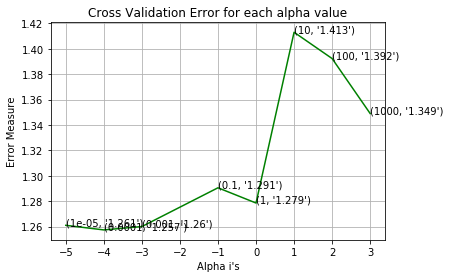

In [137]:
fig, ax = plt.subplots()
ax.plot(np.log10(alpha),cv_log_error_array,c = 'g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (np.log10(alpha[i]),cv_log_error_array[i]))
plt.grid()
plt.title('Cross Validation Error for each alpha value')
plt.xlabel("Alpha i's")
plt.ylabel('Error Measure')
plt.show()

In [155]:
best_alpha = np.argmin(cv_log_error_array)
clf = MultinomialNB(alpha= alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_onehotCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_onehotCoding)
print('For values of best alpha= ',alpha[best_alpha],'The train log loss is ',round(log_loss(train_y,predict_y),2))
predict_y = sig_clf.predict_proba(cv_x_onehotCoding)
print('For values of best alpha= ',alpha[best_alpha],'The train log loss is ',round(log_loss(cv_y,predict_y),2))
predict_y = sig_clf.predict_proba(test_x_onehotCoding)
print('For values of best alpha= ',alpha[best_alpha],'The train log loss is ',round(log_loss(test_y,predict_y),2))

For values of best alpha=  0.0001 The train log loss is  0.82
For values of best alpha=  0.0001 The train log loss is  1.26
For values of best alpha=  0.0001 The train log loss is  1.33


Test the naive Bayes Model woth best alpha on testing data.

In [223]:
def plot_confusion_matrix(y_test,y_predict):
    
    C = confusion_matrix(y_test, y_predict)  #confusion matrix
    
    A = (((C.T)/(C.sum(axis=1))).T)  # precision matrix
    
    B= (C/C.sum(axis=0))    # recall matrix
    labels = list(np.linspace(1, 9, num=9, dtype = int))
    
    print("-" * 45, 'Confusion Matrix', '-' *45)
    plt.figure(figsize=(20,7))
    sns.heatmap(C, annot = True, cmap = "YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()
    
    print('\n' * 2 )
    print("-" * 45, 'Precision Matrix', '-' *45) 
    plt.figure(figsize =(20,7))
    sns.heatmap(B, annot = True, cmap = "YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

    print('\n' * 2 )
    print("-" * 45, 'Recall Matrix', '-' *45) 
    plt.figure(figsize =(20,7))
    sns.heatmap(A, annot = True, cmap = "YlGnBu",fmt=".3f",xticklabels=labels,yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Actual Class')
    plt.show()

Log Loss : 1.4029255736651756
--------------------------------------------- Confusion Matrix ---------------------------------------------


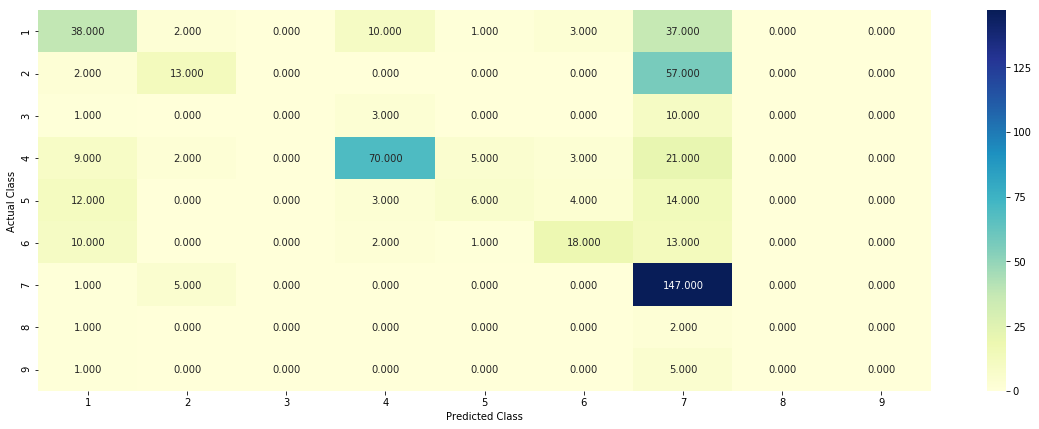




--------------------------------------------- Precision Matrix ---------------------------------------------


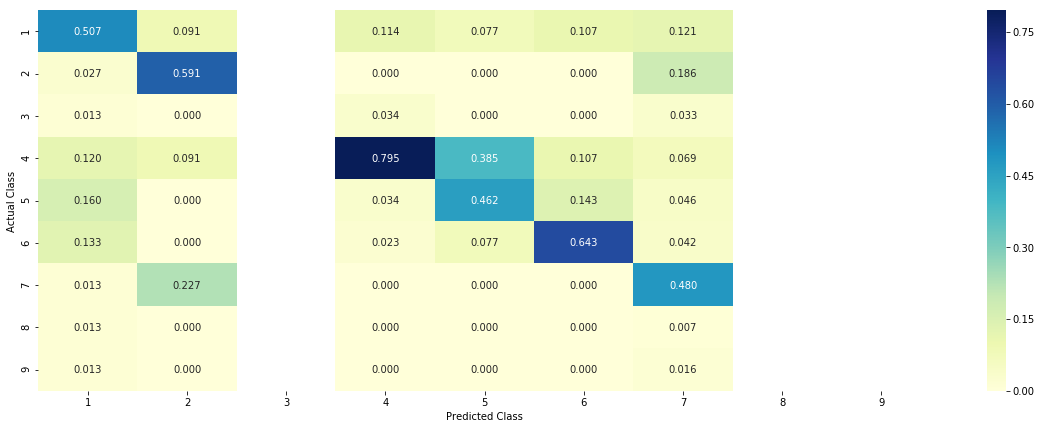




--------------------------------------------- Recall Matrix ---------------------------------------------


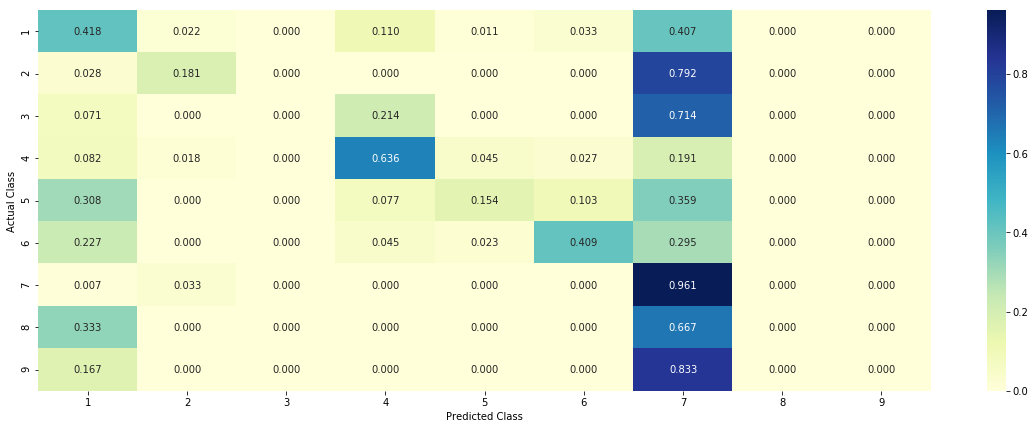

In [224]:
clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_x_onehotCoding, train_y)
sig_clf = CalibratedClassifierCV(clf, method ='sigmoid')
sig_clf.fit(train_x_onehotCoding, train_y)
sig_clf_probs = sig_clf.predict_proba(cv_x_onehotCoding)

print('Log Loss :',log_loss(cv_y,sig_clf_probs))
# print('Number of missclassified data points ',np.count_nonzero((sig_clf.predict(cv_x_onehotCoding.toarray()))))
plot_confusion_matrix(cv_y,sig_clf.predict(cv_x_onehotCoding.toarray()))



Model Interpretability

Have a look at the first point.

In [210]:
test_point_index = 1
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print('Predicted Class :', predicted_cls[0])
print('Predicted Class Probabilities:', np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print('Actual Class :', test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print('-'*50)
get_impfeature_names(indices[0],test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index],50)

Predicted Class : 6
Predicted Class Probabilities: [[0.0708 0.0831 0.0102 0.101  0.0316 0.6004 0.096  0.0039 0.003 ]]
Actual Class : 6
--------------------------------------------------
7 TEXT feature [brca] present in test data point [True]
8 TEXT feature [i124v] present in test data point [True]
11 TEXT feature [personal] present in test data point [True]
20 TEXT feature [history] present in test data point [True]
22 TEXT feature [1jm7] present in test data point [True]
Out of the top  50  features  5 are present in query point


100th point.

In [211]:
test_point_index = 100
no_feature = 100
predicted_cls = sig_clf.predict(test_x_onehotCoding[test_point_index])
print('Predicted Class :', predicted_cls[0])
print('Predicted Class Probabilities:', np.round(sig_clf.predict_proba(test_x_onehotCoding[test_point_index]),4))
print('Actual Class :', test_y[test_point_index])
indices = np.argsort(-clf.coef_)[predicted_cls-1][:,:no_feature]
print('-'*50)
get_impfeature_names(indices[0],test_df['TEXT'].iloc[test_point_index],test_df['Gene'].iloc[test_point_index],test_df['Variation'].iloc[test_point_index],100)

Predicted Class : 1
Predicted Class Probabilities: [[0.5844 0.0962 0.0118 0.117  0.0364 0.0351 0.1111 0.0045 0.0035]]
Actual Class : 1
--------------------------------------------------
11 TEXT feature [function] present in test data point [True]
12 TEXT feature [protein] present in test data point [True]
13 TEXT feature [type] present in test data point [True]
16 TEXT feature [affect] present in test data point [True]
17 TEXT feature [reduced] present in test data point [True]
18 TEXT feature [one] present in test data point [True]
19 TEXT feature [two] present in test data point [True]
20 TEXT feature [binding] present in test data point [True]
21 TEXT feature [loss] present in test data point [True]
22 TEXT feature [sequences] present in test data point [True]
23 TEXT feature [specific] present in test data point [True]
24 TEXT feature [amino] present in test data point [True]
25 TEXT feature [sequence] present in test data point [True]
26 TEXT feature [containing] present in test d

## KNN

In [215]:
alpha = [5,11,15,21,31,41,51,99]

cv_log_error_array = []

for i in alpha:
    print('for akoha = ', i)
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(train_x_responseCoding, train_y)
    sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
    sig_clf.fit(train_x_responseCoding, train_y)
    sig_clf_probs = sig_clf.predict_proba(cv_x_responseCoding)
    cv_log_error_array.append(log_loss(cv_y,sig_clf_probs, labels = clf.classes_,eps=1e-15))
    
    print('Log Loss :',log_loss(cv_y,sig_clf_probs))

for akoha =  5
Log Loss : 4.008823298593176
for akoha =  11
Log Loss : 3.7917781780121
for akoha =  15
Log Loss : 3.540341656024505
for akoha =  21
Log Loss : 3.1319400716284704
for akoha =  31
Log Loss : 2.7585968271488275
for akoha =  41
Log Loss : 2.643040320545938
for akoha =  51
Log Loss : 2.7822391115908847
for akoha =  99
Log Loss : 3.0109735211731996


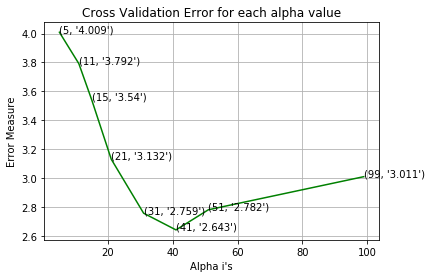

In [217]:
fig, ax = plt.subplots()
ax.plot(alpha,cv_log_error_array,c = 'g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],str(txt)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title('Cross Validation Error for each alpha value')
plt.xlabel("Alpha i's")
plt.ylabel('Error Measure')
plt.show()

In [219]:
best_alpha = np.argmin(cv_log_error_array)
clf = KNeighborsClassifier(n_neighbors= alpha[best_alpha])
clf.fit(train_x_responseCoding, train_y)
sig_clf = CalibratedClassifierCV(clf,method='sigmoid')
sig_clf.fit(train_x_responseCoding, train_y)

predict_y = sig_clf.predict_proba(train_x_responseCoding)
print('For values of best alpha= ',alpha[best_alpha],'The train log loss is ',round(log_loss(train_y,predict_y),2))
predict_y = sig_clf.predict_proba(cv_x_responseCoding)
print('For values of best alpha= ',alpha[best_alpha],'The train log loss is ',round(log_loss(cv_y,predict_y),2))
predict_y = sig_clf.predict_proba(test_x_responseCoding)
print('For values of best alpha= ',alpha[best_alpha],'The train log loss is ',round(log_loss(test_y,predict_y),2))

For values of best alpha=  41 The train log loss is  0.33
For values of best alpha=  41 The train log loss is  2.64
For values of best alpha=  41 The train log loss is  2.62


## To DO

- MORE MODELS!
- GRIDSEARCH AMONG MORE MODELS
- Type more interpretation